In [1]:
# import modules
from qutip import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
import os 

# import custom module
import spin_chain
importlib.reload(spin_chain)

# define identity for qubits 
I2 = qeye(2)

# define Pauli matrices and constants
σ_x = sigmax()
σ_y = sigmay()
σ_z = sigmaz()
π = np.pi

# font specs for plots
%matplotlib inline
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.size"] = "14"

In [2]:
# data for 2-site spin chain 
N = 2
Jx = 1
Jy = 1
Jz = 1
tolerance2 = 1e-12
H2, eigenstates2, eigenvalues2, min_eigenvalue2, ρ_ground_state2 = spin_chain.quantities(N,Jx,Jy,Jz,tolerance2)
spin_chain.verify_orthonormality(eigenstates2, tolerance2)

When N = 2 your eigenstates form an orthonormal basis!


In [3]:
# data for 3-site spin chain 
N = 3
Jx = 1
Jy = 1
Jz = 1
tolerance3 = 1e-12
H3, eigenstates3, eigenvalues3, min_eigenvalue3, ρ_ground_state3 = spin_chain.quantities(N,Jx,Jy,Jz,tolerance3)
spin_chain.verify_orthonormality(eigenstates3, tolerance3)

When N = 3 your eigenstates form an orthonormal basis!


In [14]:
# unconditional displacement operator 
def D(α, cutoff):
    
    # define operator for bosonic modes 
    a = destroy(cutoff)
    
    return (α*a.dag() - np.conj(α)*a).expm()

# operator that displaces cavity 1 by energy between spins 1 and 2
def D1_12(α, cutoff):

    # define bosonic operators 
    a = destroy(cutoff)
    Ib = qeye(cutoff)
    return (tensor(α*a.dag() - np.conj(α)*a, Ib, tensor(H2,I2))).expm() 

# operator that displaces cavity 1 by energy between spins 2 and 3
def D1_23(α, cutoff):

    # define bosonic operators 
    a = destroy(cutoff)
    Ib = qeye(cutoff)
    return (tensor(α*a.dag() - np.conj(α)*a, Ib, tensor(I2,H2))).expm()

# operator that displaces cavity 2 by energy between spins 1 and 2
def D2_12(α, cutoff):

    # define bosonic operators 
    a = destroy(cutoff)
    Ib = qeye(cutoff)
    return (tensor(Ib, tensor(α*a.dag() - np.conj(α)*a, tensor(H2,I2)))).expm() 

# operator that displaces cavity 2 by energy between spins 2 and 3
def D2_23(α, cutoff):

    # define bosonic operators 
    a = destroy(cutoff)
    Ib = qeye(cutoff)
    return (tensor(Ib, tensor(α*a.dag() - np.conj(α)*a, tensor(I2,H2)))).expm()

# operator that displaces cavity 1 by energy between spins 1,2, and 3
def D1_tot(α, E_n, cutoff):
    
    # define bosonic operators 
    a = destroy(cutoff)
    Ib = qeye(cutoff)
    return (tensor(α*a.dag() - np.conj(α)*a, Ib, (H3 - E_n*tensor(I2, I2,I2)))).expm() 

# operator that displaces cavity 2 by energy between spins 1,2, and 3
def D2_tot(α, E_n, cutoff):
    
    # define bosonic operators 
    a = destroy(cutoff)
    Ib = qeye(cutoff)
    return (tensor(Ib, α*a.dag() - np.conj(α)*a, (H3 - E_n*tensor(I2, I2,I2)))).expm() 

# operator that uses Trotterization to displace cavity 1 by energy between spins 1,2 and 3
def D1_tot_trotter(α, E_n, r, cutoff):
    
    # define bosonic operators 
    Ib = qeye(cutoff)
    
    # return Trotterized conditional displacement operator that 
    # that is unconditionally shifted by α*E_n
    return ((D1_23(α/r, cutoff)*D1_12(α/r, cutoff))**r)*tensor(D(-E_n*α, cutoff),Ib,I2,I2,I2)

# operator that uses Trotterization to displace cavity 2 by energy between spins 1,2 and 3
def D2_tot_trotter(α, E_n, r, cutoff):
    
    # define bosonic operators 
    Ib = qeye(cutoff)
    
    # return Trotterized conditional displacement operator that 
    # that is unconditionally shifted by α*E_n
    return ((D2_12(α/r, cutoff)*D2_23(α/r, cutoff))**r)*tensor(Ib,D(-E_n*α, cutoff),I2,I2,I2)

# operator that uses parallelized Trotter
def D12_tot_trotter(α, E_n, r, cutoff):
    
    # define bosonic operators 
    Ib = qeye(cutoff)
    
    # return Trotterized conditional displacement operator that 
    # that is unconditionally shifted by α*E_n
    return ((D2_23(α/r, cutoff)*D1_23(α/r, cutoff)*D2_12(α/r, cutoff)*D1_12(α/r, cutoff))**r) \
            *tensor(D(-E_n*α, cutoff),D(-E_n*α, cutoff),I2,I2,I2)

# # function to check convergence of Trotterization scheme
# def convergence_analysis(D_exact, D_approx, α, ϵ):
    
#     # compute Frobenius norm for one order of Trotterization
#     r = 1
#     frobenius_norm = np.linalg.norm(D_exact(α) - D_approx(α, r), 'fro')

#     # find value of r that satisfies || D_exact - D_approx ||_F
#     while frobenius_norm >= ϵ:
#         r += 1
#         frobenius_norm = np.linalg.norm(D_exact(α) - D_approx(α, r), 'fro')
#     print(f'For r = {r} and \u03B1 = {α} the Frobenius norm is {frobenius_norm:.4f} ')
    
# # define parameters
# α = 1
# ϵ = 5
# E_n = min_eigenvalue3
# cutoff = 5

# # define functions we wish to compare
# GSP12_tot = lambda α: D2_tot(α, E_n, cutoff)*D1_tot(α, E_n, cutoff)
# GSP12_trotter_old = lambda α, r: D2_tot_trotter(α, E_n, r, cutoff)*D1_tot_trotter(α, E_n, r, cutoff)
# GSP12_trotter_new = lambda α, r: D12_tot_trotter(α, E_n, r, cutoff)
# convergence_analysis(GSP12_tot, GSP12_trotter_new, α, ϵ)

In [25]:
N_qubits = 3
N_cavities = 2
m_start = 2
m_stop = 2
α_start = 0
α_end = 0.6
α_steps = 75
λ = 1
E_n = min_eigenvalue3
r = 1
num_states = 3
cutoff = 9
save_file = True
initial_state_list = spin_chain.generate_initial_states(N_cavities, N_qubits, num_states, cutoff)

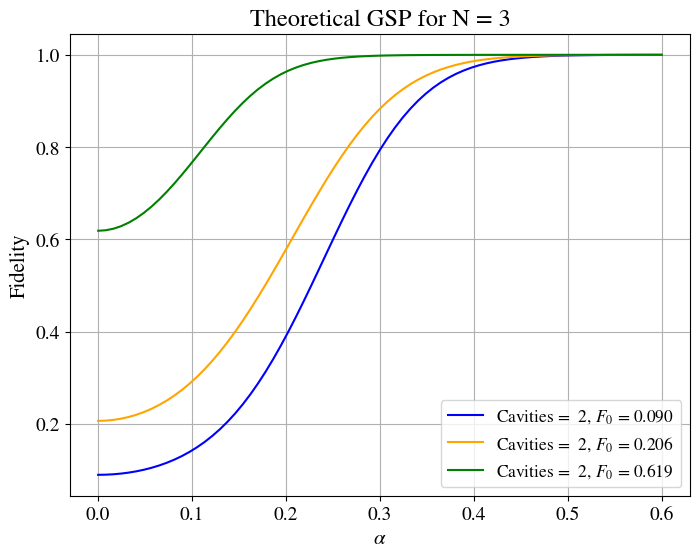

In [27]:
theoretical_fidelity_array_list = spin_chain.plot_fidelity(N_cavities, N_qubits, eigenvalues3, eigenstates3, m_start, m_stop, \
              α_start, α_end, α_steps, initial_state_list, cutoff, save_file)

In [28]:
def trotterized_ground_state_projection(α_start, α_end, α_steps, λ, E_n, r, m_start, m_stop, \
                                        initial_state_list, cutoff, save_file):

    # define operators for bosonic modes 
    a = destroy(cutoff)
    Ib = identity(cutoff)

    # define vacuum state for a cavity, and spin up and spin down states for qubits
    vacuum = basis(cutoff, 0)
    up = basis(2,0)
    down = basis(2,1)

    # define projection operators that project onto vacuum either cavity 1 
    # or cavities 1 and 2 
    vacuum_projector = vacuum*vacuum.dag()
    P_vac1 = tensor(vacuum_projector, Ib, I2, I2, I2)
    P_vac12 = tensor(vacuum_projector, vacuum_projector, I2, I2, I2) 
    
    # create array over which to sweep α
    α_array = np.linspace(α_start, α_end, α_steps)
    
    # list of numbers of cavities we will project onto the ground state
    cavity_list = list(range(m_start, m_stop+1))

    # define ground state preparation algorithm without Trotterization
    # GSP_exact = lambda α: D2_tot(α, E_n, cutoff)*D1_tot(α, E_n, cutoff)
    GSP = lambda α: D12_tot_trotter(α, E_n, r, cutoff)

    # compute projection fidelity data without Trotterization
    simulated_fidelity_array_list = [[expect(ρ_ground_state3, \
                                            ((P_vac12*GSP(α)*initial_state).unit()).ptrace([2,3,4])) \
                                      for α in α_array] \
                                      for initial_state in initial_state_list]

    # define list of colors to use for plots 
    colors = ['blue', 'orange', 'green','red', 'purple', 'black', 'pink', 'gray', 'cyan', 'magenta']
        
    # generate custom linestyles to use if we are projecting 4 or more cavities onto vacuum
    dashed_list = [(None, None), (5, 2), (1, 2), (5, 2, 1, 2), (10, 5, 2, 5), \
                   (2, 2, 10, 2), (5, 2, 10, 2, 5, 2), (15, 5, 5, 5), (2, 5, 10, 5)]

    fig, ax = plt.subplots(figsize=(8, 6))
    
    # graph the theoretical projection of all initial states onto the true ground state 
    for i in range(len(theoretical_fidelity_array_list)):
        for j, fidelity_array in enumerate(theoretical_fidelity_array_list[i]):
            ax.plot(α_array, fidelity_array, \
                    label=f'Exact, M =  {cavity_list[j]}, $F_0$ = {fidelity_array[0] :.3f}', \
                    color=colors[i], linestyle='-', dashes = dashed_list[(len(cavity_list) - 1) - j])

    # graph the theoretical projection of all initial states onto the true ground state 
    for i, fidelity_array in enumerate(simulated_fidelity_array_list): 
        ax.plot(α_array, fidelity_array, label=f'Trotterized, M = 2, $F_0$ = {fidelity_array[0] : .3f}', \
                color=colors[i], linestyle='--')
        
    ax.set_xlabel(r'$\alpha$', fontsize=15)
    ax.set_ylabel('Fidelity', fontsize=15)
    ax.set_title(f'Trotterized GSP with r = {r} for N = 3', fontsize=17.5)  
    ax.legend(fontsize = 12.5)
    ax.grid(True)
    
    if save_file: 
    
        # define which folder subfolder in /data to store the image
        if N_qubits == 2: 
            site_folder = 'two_sites'
        elif N_qubits == 3: 
            site_folder = 'three_sites'
        elif N_qubits == 4: 
            site_folder = 'four_sites'
        elif N_qubits == 5: 
            site_folder = 'five_sites'

        # calculate number of states that were simulated
        num_states = len(initial_state_list)

        if m_start != m_stop: 

            # create name for png file 
            filename = f'/Users/lukebell/Documents/boson_gang/data/{site_folder}/simulated_' \
                        f's{num_states}_m{m_start}{m_stop}_r{r}.png'

            # Check if the file already exists
            if os.path.exists(filename):
                # If it exists, remove it
                os.remove(filename)

            # save figure 
            plt.savefig(filename)

        elif m_start == m_stop: 

            # create name for png file 
            filename = f'/Users/lukebell/Documents/boson_gang/data/{site_folder}/simulated_' \
                        f's{num_states}_m{m_start}_r{r}.png'

        # Check if the file already exists
        if os.path.exists(filename):
            # If it exists, remove it
            os.remove(filename) 

        # save figure 
        plt.savefig(filename)

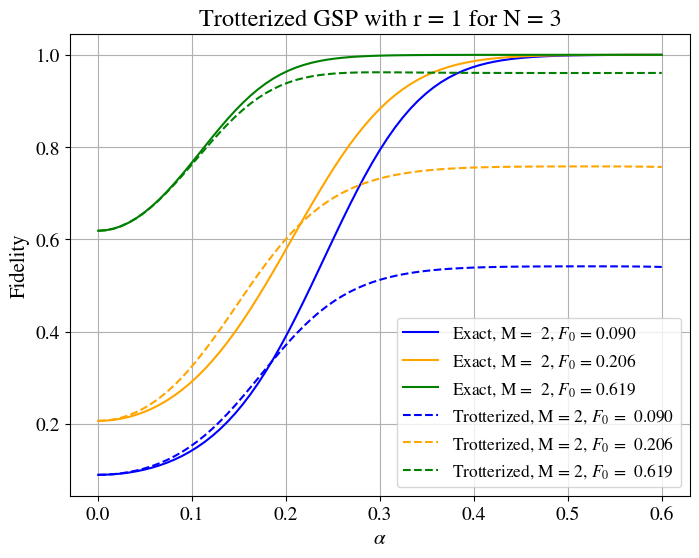

In [29]:
save_file = True
r = 1
trotterized_ground_state_projection(α_start, α_end, α_steps, λ, E_n, r, m_start, m_stop, \
                                    initial_state_list, cutoff, save_file)

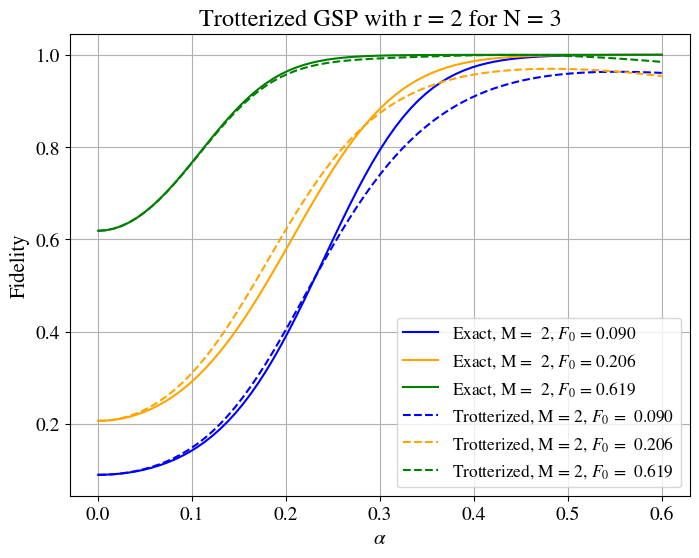

In [31]:
save_file = True
r = 2
trotterized_ground_state_projection(α_start, α_end, α_steps, λ, E_n, r, m_start, m_stop, \
                                    initial_state_list, cutoff, save_file)

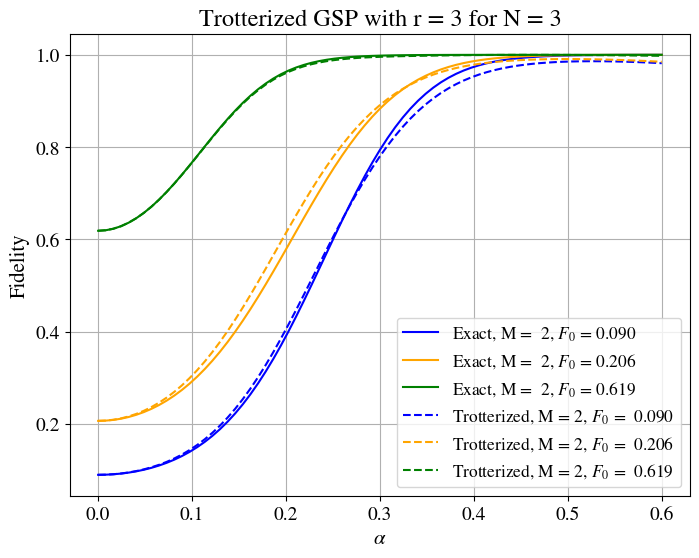

In [32]:
save_file = True
r = 3
trotterized_ground_state_projection(α_start, α_end, α_steps, λ, E_n, r, m_start, m_stop, \
                                    initial_state_list, cutoff, save_file)

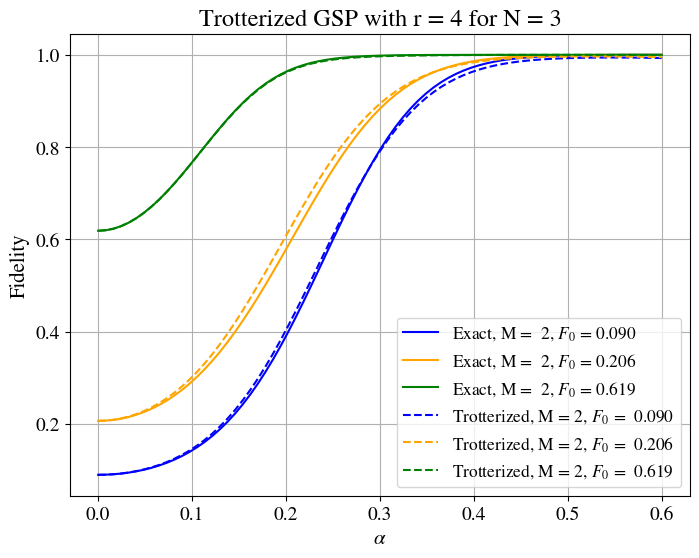

In [33]:
save_file = True
r = 4
trotterized_ground_state_projection(α_start, α_end, α_steps, λ, E_n, r, m_start, m_stop, \
                                    initial_state_list, cutoff, save_file)

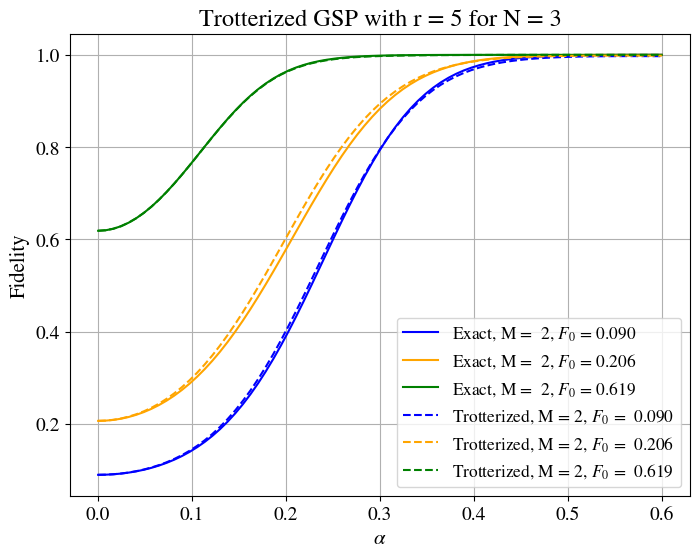

In [34]:
save_file = True
r = 5
trotterized_ground_state_projection(α_start, α_end, α_steps, λ, E_n, r, m_start, m_stop, \
                                    initial_state_list, cutoff, save_file)

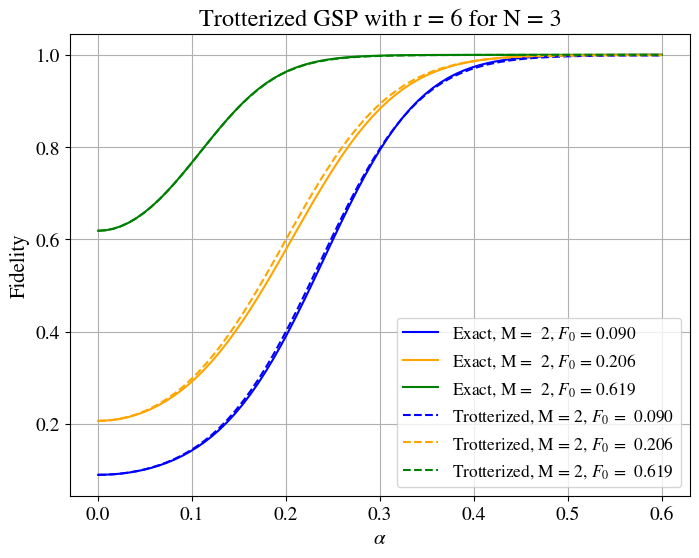

In [35]:
save_file = True
r = 6
trotterized_ground_state_projection(α_start, α_end, α_steps, λ, E_n, r, m_start, m_stop, \
                                    initial_state_list, cutoff, save_file)

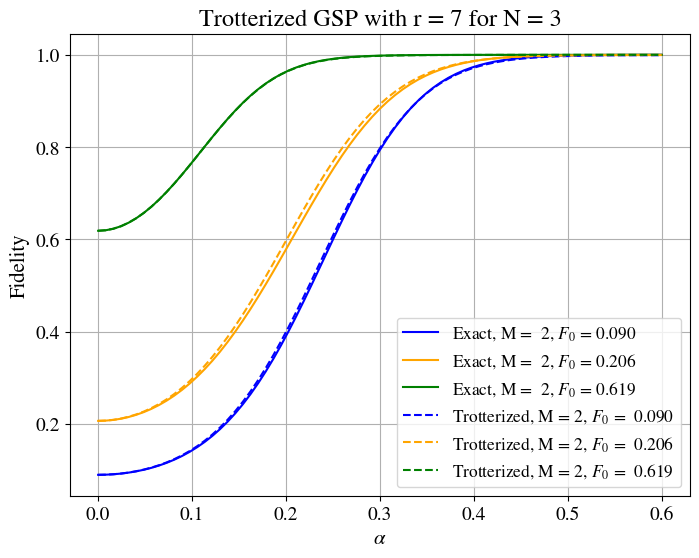

In [36]:
save_file = True
r = 7
trotterized_ground_state_projection(α_start, α_end, α_steps, λ, E_n, r, m_start, m_stop, \
                                    initial_state_list, cutoff, save_file)

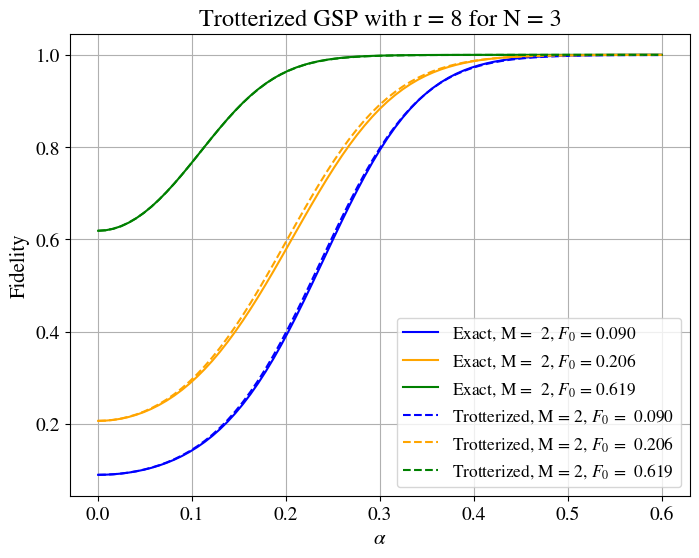

In [37]:
save_file = True
r = 8
trotterized_ground_state_projection(α_start, α_end, α_steps, λ, E_n, r, m_start, m_stop, \
                                    initial_state_list, cutoff, save_file)

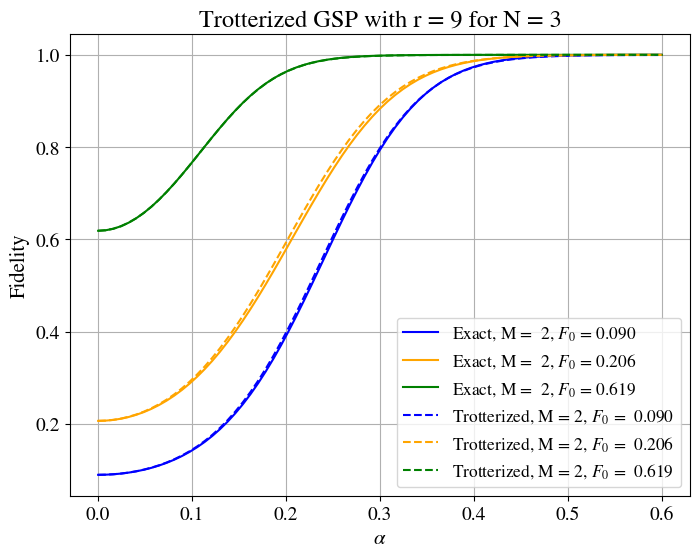

In [38]:
save_file = True
r = 9
trotterized_ground_state_projection(α_start, α_end, α_steps, λ, E_n, r, m_start, m_stop, \
                                    initial_state_list, cutoff, save_file)

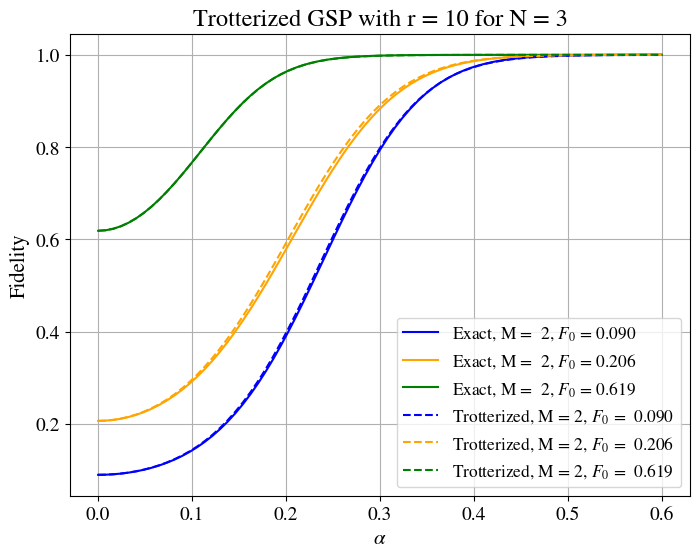

In [39]:
save_file = True
r = 10
trotterized_ground_state_projection(α_start, α_end, α_steps, λ, E_n, r, m_start, m_stop, \
                                    initial_state_list, cutoff, save_file)